In [14]:
import pandas as pd
from auxiliary.filter_functions import filter_chandra, filter_archival, filter_gaia, filter_ned, filter_simbad, filter_erosita, filter_vizier
from auxiliary.search_algorithm import get_wcs_event, off_axis, get_chandra_eef, get_counts_from_event
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad, SimbadClass
import os
import glob
from astropy.table import Table
import numpy as np
from astropy.io import fits
import time
import matplotlib.pyplot as plt

# 2372400

In [19]:
def gen_light_curve(obsid: int, fxt_ra: float, fxt_dec: float, fxt_theta: float, fxt_pos_err: float) -> pd.DataFrame:
    t1 = time.perf_counter()

    # get files
    try:
        files = glob.glob(
            f'/data/jcrans/fxrt-data/obsids/{obsid}/s3_expmap_src.fits', recursive=True)
        src_file = files[0]
        files = glob.glob(
            f'/data/jcrans/fxrt-data/obsids/{obsid}/*evt2.fits', recursive=True)
        event_file = files[0]
    except IndexError:
        print(f'No files found for {obsid}')
        return pd.DataFrame()
    
    t2 = time.perf_counter()

    # Read the event file
    event_data_raw = Table.read(event_file, hdu=1)

    # Read the wcs of the event file
    event_wcs = get_wcs_event(event_file)
    
    # convert ra, dec to x, y
    fxt_x, fxt_y = event_wcs.all_world2pix(fxt_ra, fxt_dec, 1)
    
    # Get R90 size
    r90_size = get_chandra_eef(np.array([fxt_theta]), R0=1.07, R10=9.65, alpha=2.22)[0]

    # Convert to pixel scale
    acis_pix_size = 0.492
    r90_size /= acis_pix_size

    # Get the aperture size
    aperture_radii = r90_size * 1.5

    event_data = event_data_raw[np.where(
        (event_data_raw['energy'] >= 5e2) &
        (event_data_raw['energy'] <= 7e3)
    )]

    t3 = time.perf_counter()

    time_bins = np.arange(event_data_raw['time'].min(), event_data_raw['time'].max(), 1000)
    light_curve = np.zeros(len(time_bins)-1)

    for i in range(len(time_bins)-1):
        event_data_bin = event_data[np.where(
            (event_data['time'] >= time_bins[i]) &
            (event_data['time'] < time_bins[i+1])
        )]

        total_counts, background_counts = get_counts_from_event(
            event_data_bin, fxt_x, fxt_y, aperture_radii, aperture_radii+22)
        
        # print('counts', total_counts, background_counts)

        light_curve[i] = total_counts - background_counts

    t4 = time.perf_counter()

    print(f't2-t1: {t2-t1:.2f}')
    print(f't3-t2: {t3-t2:.2f}')
    print(f't4-t3: {t4-t3:.2f}')

    return pd.DataFrame({
        'time': time_bins[:-1],
        'counts': light_curve
    })


lc_df = gen_light_curve(803, 186.3815785116022, 13.066452477077808, 13.285, 0.230628978992878)

t2-t1: 0.00
t3-t2: 0.22
t4-t3: 0.02


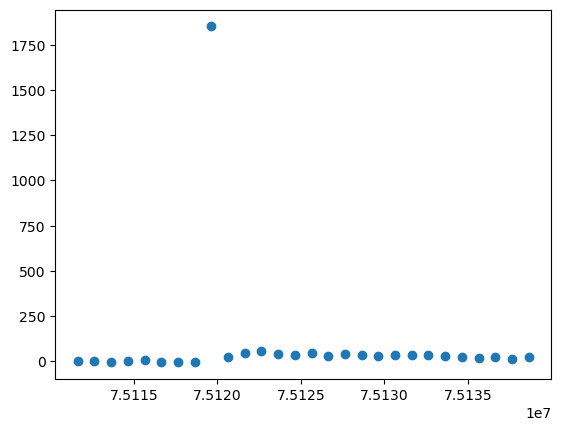

In [20]:
plt.scatter(lc_df['time'], lc_df['counts'])
plt.show()

In [9]:
detections = pd.read_csv('output/detections_w20.txt',
                         header=0, sep=' ', dtype=str)

detection = detections[detections['ObsId'] == '8490'].iloc[0]

filter_simbad(detection, True)

            MAIN_ID             RA            DEC    OTYPE    OTYPES
0  UCAC4 105-012588  05 29 02.8601  -69 04 29.953  EmLine*  Em*|PN|*


True

In [26]:
filterd = pd.read_csv('output/filtered_w20.csv', header=0, dtype=str)
obsids_after1 = pd.read_csv('obsid_lists/obsids_b+10_220401+.csv', header=0, dtype=str, sep=',', usecols=[1])
obsids_after2 =  pd.read_csv('obsid_lists/obsids_b-10_220401+.csv', header=0, dtype=str, sep=',', usecols=[1])
obsids_after = pd.concat([obsids_after1, obsids_after2], ignore_index=True)
print(f'after total: {len(obsids_after)}')

obsids_before1 = pd.read_csv('obsid_lists/obsids_b+10_220401-.csv', header=0, dtype=str, sep=',', usecols=[1])	
obsids_before2 = pd.read_csv('obsid_lists/obsids_b-10_220401-.csv', header=0, dtype=str, sep=',', usecols=[1])
obsids_before = pd.concat([obsids_before1, obsids_before2], ignore_index=True)
print(f'before total: {len(obsids_before)}')

filtered_post = filterd[filterd['ObsId'].isin(obsids_after['Obs ID'])]
filtered_pre = filterd[filterd['ObsId'].isin(obsids_before['Obs ID'])]
filtered_post.to_csv('output/filtered_w20_new.csv', index=False)
filtered_pre.to_csv('output/filtered_w20_old.csv', index=False)

print(f'after detec: {len(filtered_post)}')
print(f'before detec: {len(filtered_pre)}')

filtered_post_all_no = filtered_post[
    (filtered_post['gaia_match'] == 'no') &
    (filtered_post['simbad_match'] == 'no') &
    (filtered_post['ned_match'] == 'no') &
    (filtered_post['archival_match'] == 'no') &
    (filtered_post['chandra_match'] == 'no') &
    (filtered_post['erosita_match'] == 'no')
]

filtered_pre_all_no = filtered_pre[
    (filtered_pre['gaia_match'] == 'no') &
    (filtered_pre['simbad_match'] == 'no') &
    (filtered_pre['ned_match'] == 'no') &
    (filtered_pre['archival_match'] == 'no') &
    (filtered_pre['chandra_match'] == 'no') &
    (filtered_pre['erosita_match'] == 'no')
]

print(f'after no match: {len(filtered_post_all_no)}')
print(f'before no match: {len(filtered_pre_all_no)}')

after total: 1495
before total: 8304
after detec: 101
before detec: 1721
after no match: 30
before no match: 332
